# RDR Reference Scenario 6 - Public Data Earthquake Hazard Example
This helper notebook walks the user through the workflow of how the RS6 hazard exposure files were created. The methodology is earthquake-specific and relies on the publicly available data sources listed below. Besides the National Bridge Inventory (NBI) layer, which must be downloaded separately by the user, all other data are packaged in the `rs6_Public_Data_Prep.zip` file in the RS6 scenario folder. Create a folder at the file path `C:\Projects\RDR`, and extract the contents of the ZIP file into this folder such that there is a CSV file at the path `C:\Projects\RDR\HAZUS_tables_bridge_earthquake.csv`. Download the NBI layer into this same folder; at this point the user should be able to follow along with the steps in this notebook.

- Start with a shapefile of a road network, in this case the Ferndale base network, prepared from OpenStreetMap and Caltrans traffic data
- Overlay the USGS earthquake data to extract the shaking metrics from the 2022 Ferndale quake
- Join the National Bridge Inventory (NBI) layer to the road network
- Extract NBI attributes needed for fragility analysis
- Apply earthquake shaking and bridge metrics to generate network link availability under earthquake hazard
 
The output of this process will be a file with link availability as modified by specific earthquake hazards for use in RDR.

Hazard Data Needed:

- [NBI feature service from BTS](https://geodata.bts.gov/maps/5e58970e89934e818f38772859addf43): 
  + Download shapefile of 621k bridges,
  + Or download Geodatabase from [ArcGIS Hub](https://hub.arcgis.com/datasets/a9b05a595ff94f3fa3888d1240545740_0/explore), which is a bit easier.

- [USGS Earthquake Catalog for Ferndale Quake](https://earthquake.usgs.gov/earthquakes/eventpage/nc73821036/executive)
  + Download the `ShakeMap Shape Files` under Shakemap > Downloads. The layers for Peak Spectral Acceleration (PSA) measure the maximum force applied in a vibration. Spectral acceleration values are used in the bridge fragility calculaations to translate from shaking to expected damage.
  
- [USGS National Seismic Hazard Model](https://www.usgs.gov/data/data-release-2023-us-50-state-national-seismic-hazard-model-overview)

Hazard Reference:

- [FEMA HAZUS](https://www.fema.gov/flood-maps/tools-resources/flood-map-products/hazus/software)
  + Bridge fragility curve reference.


In [ ]:
import arcpy
from pathlib import Path
import os
import pandas as pd
import re
import numpy as np
import datetime

# Do not draw each output on the map
arcpy.env.addOutputsToMap = False

%matplotlib inline

project_dir = "C:\Projects\RDR"
if os.path.exists(os.path.join(project_dir, 'RDR.gdb')):         
    pass
else:         
    arcpy.management.CreateFileGDB(out_folder_path = project_dir, 
                                   out_name = 'RDR')
arcpy.env.workspace = project_dir + r"\RDR.gdb"

print('Project directory:\n', project_dir)
print('Default gdb:\n', arcpy.env.workspace)

hazus_df = pd.read_csv(os.path.join(project_dir, 'HAZUS_tables_bridge_earthquake.csv'))

In [ ]:
def getFieldNames(shp):
    fieldnames = [f.name for f in arcpy.ListFields(shp)]
    return fieldnames

def feature_class_to_pandas_data_frame(feature_class, field_list):
    return pd.DataFrame(
        arcpy.da.FeatureClassToNumPyArray(
            in_table=feature_class,
            field_names=field_list,
            skip_nulls=False,
            null_value=-99999
        )
    )

## National Bridge Inventory attributes needed

- State
- Year Built
- Skew
- Type
- Number of Spans
- Maximum Span Length (ft)
- Total Bridge Length (ft)
- Bridge Width (ft)
- AADT
- Detour Length (miles)
- AADTT (%)

In particular, the HAZUS process needs these values:
- `YEAR_BUILT_027`
- `MAX_SPAN_LEN_MT_048`
- `STATE_CODE_001`


## Add Ferndale network

Prepared from OpenStreetMap (OSM) data. 

In [ ]:
source_network_path = 'Ferndale_Network_Shape/Link'
source_network = os.path.split(source_network_path)[1]

fc_list = arcpy.ListFeatureClasses()

# Add road network shapefile as feature class in the default gdb
if source_network not in fc_list:
    source_network_shape = source_network_path + '.shp' 
    if not os.path.exists(os.path.join(project_dir, source_network_shape)):
        print('{} network shapefile not found in {}'.format(source_network_shape, project_dir))
    else:
        arcpy.CopyFeatures_management(os.path.join(project_dir, source_network_shape), source_network)

## Add National Bridge Inventory 

Overlay the NBI values with network. This assumes the NBI geodatabase has been downloaded and is in the project directory.

In [ ]:
join_source = "NBI.gdb"
join = "National_Bridge_Inventory"

# Simplify the NBI file
colnames = getFieldNames(os.path.join(join_source, join))

In [ ]:
colnames

In [ ]:
keep_cols = ['OBJECTID', 'shape', 'LATDD', 'LONDD', 
             'state_code_001', 'year_built_027', 'degrees_skew_034',
             'structure_type_043b', 'main_unit_spans_045', 'max_span_len_mt_048',
             'structure_len_mt_049', 'deck_width_mt_052', 'adt_029',
             'detour_kilos_019', 'percent_adt_truck_109']

keep_cols = [x.upper() for x in keep_cols]

In [ ]:
drop_fields = []

for name in colnames[1:]:
    if name not in keep_cols:
        drop_fields.append(name)


In [ ]:
# Make copy and simplify
arcpy.management.CopyFeatures(in_features = os.path.join(join_source, join),
                              out_feature_class = join)
        
if len(drop_fields) > 0:
    arcpy.management.DeleteField(in_table = join, drop_field = drop_fields)

In [ ]:
network_with_bridge = 'Ferndale_Bridge' 

arcpy.analysis.SpatialJoin(source_network,
                           join,
                           network_with_bridge,
                           match_option = "WITHIN_A_DISTANCE",
                           search_radius = '50 Meters')

In [ ]:
# Optional: select just the Fernbridge
arcpy.analysis.Select(
    in_features = network_with_bridge,
    out_feature_class = network_with_bridge + '_Select',
    where_clause = "name = 'Fernbridge'"
)

## Overlay Earthquake Hazard

Now, overlay the earthquake hazard information. This assumes that the zip of quake shapefiles has been downloaded from the USGS earthquake catalog and unzipped in the ArcGIS project folder. Here it is in the directory `Ferndale_Quake_Shape`.

This section will extract the short (0.3 second) and long (1 second) peak spectral acceleration values for this quake to the road segments.

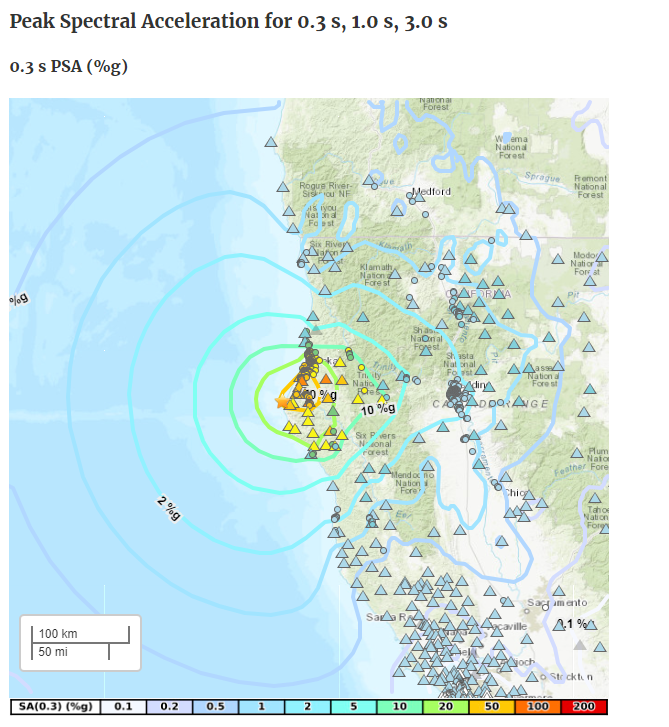

In [ ]:
fc_list = arcpy.ListFeatureClasses()

source_quake_paths = ['Ferndale_Quake_Shape/psa1p0',
                      'Ferndale_Quake_Shape/psa0p3']

for q in source_quake_paths:
    source_quake = os.path.split(q)[1]

    # Add quake shapefile as feature class in the default gdb
    if source_quake not in fc_list:
        source_quake_shape = q + '.shp' 
        print('Converting ' + source_quake_shape)
        arcpy.conversion.FeatureClassToGeodatabase(
            Input_Features = os.path.join(project_dir, source_quake_shape),
            Output_Geodatabase = arcpy.env.workspace
        )
    
    arcpy.management.DefineProjection(
        in_dataset = source_quake,
        coor_system = 'GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
    )
            

In [ ]:
network_with_bridge

In [ ]:
# Extract raster values to network links

use_layer = network_with_bridge  

quake_shapes = ['psa1p0',
                'psa0p3']

print('Starting at ' + str(datetime.datetime.now()))

for i in range(len(quake_shapes)):
    m = quake_shapes[i]
    
    print('Processing ' + str(m) + ', shape ' + str(i))
    
    if i == 0:
        this_layer_in = use_layer
        this_layer_out = use_layer + '_quake' + str(i)
    else:
        this_layer_in = use_layer + '_quake' + (str(i-1))
        this_layer_out = use_layer + '_quake' + str(i)
        
    print('m:\t' + m)
    print('IN:\t' + this_layer_in)
    print('OUT:\t' + this_layer_out)
       
    arcpy.analysis.SpatialJoin(
        target_features = this_layer_in,
        join_features= m,
        out_feature_class = this_layer_out,
        join_operation = 'JOIN_ONE_TO_ONE',
        join_type = "KEEP_ALL",
        match_option="INTERSECT",
        search_radius = None,
        distance_field_name = '')
    
    # Rename field 
    arcpy.management.AlterField(
        in_table = this_layer_out,
        field = 'PARAMVALUE',
        new_field_name = m,
        new_field_alias = m)
    
print('Finished at ' + str(datetime.datetime.now()))

## Apply earthquake hazards

Apply one real and one hypothetical earthquake to the area, across all links.
- [MMI](https://en.wikipedia.org/wiki/Modified_Mercalli_intensity_scale), Modified Mercalli intensity, represents the shaking felt at a quake. This value is used rather than the Richter scale magnitude at the epicenter, since it represents the amount of actual shaking felt at a location, specific to the distance from the epicenter and geologic factors.
- [PGA](https://en.wikipedia.org/wiki/Peak_ground_acceleration), Peak Ground Acceleration, is used to represent how fast the shaking was at a specific location. PGA rasters can also be downloaded from the USGS Earthquake catalog for recent quakes.
- [PSA](https://www.usgs.gov/programs/earthquake-hazards/science/earthquake-hazards-201-technical-qa#:~:text=Spectral%20acceleration%20is%20a%20measure,say%2C%200.2%2D0.6%20sec.), Peak Spectral Acceleration, measures the maximum force applied in a vibration. Spectral acceleration values are used in the FHWA Bridge Fragility calculator to translate from shaking to expected damage.

The real quake is the 2022 Ferndale quake, which has already been applied above. The hypothetical one is where the PSA values are multiplied by 1.25.

In [ ]:
# Quake values: Peak Spectral Acceleration at this location
# Vector of S_s, short period spectral acceleration, one for each quake
# Vector of S_1, 1 second period spectral acceleration, one for each quake

# Turn to pandas dataframe
fieldnames = getFieldNames(this_layer_out)
fieldnames_select = fieldnames[2:len(fieldnames)]

df = feature_class_to_pandas_data_frame(this_layer_out, fieldnames_select).replace(-99999, 0)

In [ ]:
# Shape factor: ratio of 1 second to short period spectral acceleration  
df['shape_factor'] = (2.5 * df['psa1p0'] / df['psa0p3'] ) 

In [ ]:
# Method for translating bridge characteristics on a link to damage and link availability
# Filter to links with a bridge 
df_filter = df[df['STATE_CODE_001'] != '-999']
print(df_filter.shape)
df_filter.head(3)

In [ ]:
# Function to look up HAZUS bridge types
def bridge_type_lookup(year_built, span_length, span_number, state):
    if state == '06':
        use_state = 'CA'
    else:
        use_state = 'Non-CA'

    use_hazus = hazus_df.loc[(hazus_df['State'] == use_state) & (year_built < hazus_df['Year Built Max']) & (year_built >= hazus_df['Year Built Min'])]

    if span_length < 20:
        use_hazus = use_hazus.loc[hazus_df['Length <20m'] == 'Yes']
    else:
        use_hazus = use_hazus.loc[hazus_df['Length <20m'] != 'Yes']
        
    if len(use_hazus['Class']) > 1 and state != '06':
        if span_number == 1:
            use_hazus = use_hazus.loc[hazus_df['# Spans'] == 1]
        else:
            use_hazus = use_hazus.loc[hazus_df['# Spans'] != 1]

        if span_length > 150:
            use_hazus = use_hazus.loc[hazus_df['Length of Max Span (m)'] == 150]
        else:
            use_hazus = use_hazus.loc[hazus_df['Length of Max Span (m)'] != 150]

    # Fallback if multiple types still present - non California
    if (len(use_hazus['Class']) > 0) & (use_hazus['Class'].str.contains('HWB12').any()):
        use_hazus = use_hazus.loc[hazus_df['Class'] == 'HWB12']
    # Fallback if multiple types still present - California
    elif (len(use_hazus['Class']) > 0) & (use_hazus['Class'].str.contains('HWB25').any()):
        use_hazus = use_hazus.loc[hazus_df['Class'] == 'HWB25']
    else:
        use_hazus = use_hazus.copy()

    return str(use_hazus['Class'].iloc[0])

# Function to calculate adjusted spectral acceleration
def adjusted_Sa(damage_type, soil_factor_1sec, bridge_params):
    """
    damage_type - moderate, extensive, or collapse
    bridge_params - single row of a dataframe with following parameters:
        bridge_type_class - HAZUS bridge type classification
        skew_factor
        arching_effect
        Ishape
        median_Sa_moderate - median spectral acceleration which results in moderate damage
    shape_factor - quake specific
    soil_factor_1sec - soil factor, 1 second period
    """
    bridge_type_class = bridge_params['bridge_type_class']
    skew_factor = bridge_params['skew_factor']
    arching_effect = bridge_params['arching_effect']
    Ishape = bridge_params['Ishape']
    median_Sa_slight = bridge_params['median_Sa_slight']
    median_Sa_moderate = bridge_params['median_Sa_moderate']
    median_Sa_extensive = bridge_params['median_Sa_extensive']
    median_Sa_collapse = bridge_params['median_Sa_collapse']
    shape_factor = bridge_params['shape_factor']
        
    if damage_type == 'slight':
        if Ishape == 0:
            mult = 1
        if Ishape == 1:
            mult = min(shape_factor, 1)

        result = mult * median_Sa_slight / soil_factor_1sec

    if damage_type == 'moderate':
        # skew * arching_factor * median_Sa_moderate/soil_factor
        result = skew_factor * arching_effect * median_Sa_moderate / soil_factor_1sec

    if damage_type == 'extensive':
        use_median_Sa = median_Sa_extensive
        result = skew_factor * arching_effect * median_Sa_extensive / soil_factor_1sec

    if damage_type == 'collapse':
        use_median_Sa = median_Sa_collapse
        result = skew_factor * arching_effect * median_Sa_collapse / soil_factor_1sec
        
    return result

# Function for the fragility curve, dependent on the spectral acceleration and the adjusted Sa above
def fragility_curve(Sa, adjusted_Sa):
    from scipy.stats import lognorm    
    logdist = lognorm(scale = adjusted_Sa, s = 0.6)
    return logdist.cdf(x = Sa)

def arching_effect_type(bridge_type, span_number):
    # 1 + A / (spans - B)
    A = hazus_df.loc[hazus_df['Class'] == bridge_type]['A'].iloc[0]
    B = hazus_df.loc[hazus_df['Class'] == bridge_type]['B'].iloc[0]
    
    if span_number != 1:
        arch = 1 + A / (span_number - B)
    else:
        arch = 1
    return arch


## Generating `haz1`: Real earthquake hazard (Ferndale 2022)

In [ ]:
# Bridge Fragility Parameters lookup
# Values based on HAZUS lookup, build a HAZUS lookup for these bridges
site_class = 'C'
soil_factor_short = 1.04
soil_factor_1sec = 1.54

bridge_params = pd.DataFrame()

for i in range(len(df_filter['link_id'])):
    link_id = df_filter.iloc[i]['link_id']
    year_built = df_filter.iloc[i]['YEAR_BUILT_027']
    span_length = df_filter.iloc[i]['MAX_SPAN_LEN_MT_048']
    span_number = df_filter.iloc[i]['MAIN_UNIT_SPANS_045']
    state = df_filter.iloc[i]['STATE_CODE_001']

    bridge_type_class = bridge_type_lookup(year_built, span_length, span_number, state)
    
    median_Sa_slight = hazus_df[hazus_df['Class'] == bridge_type_class]['Sa2'].iloc[0]
    median_Sa_moderate = hazus_df[hazus_df['Class'] == bridge_type_class]['Sa3'].iloc[0]
    median_Sa_extensive = hazus_df[hazus_df['Class'] == bridge_type_class]['Sa4'].iloc[0]
    median_Sa_collapse = hazus_df[hazus_df['Class'] == bridge_type_class]['Sa5'].iloc[0]
    arching_effect = arching_effect_type(bridge_type_class, span_number)

    # Ishape: depends on bridge_type_class
    Ishape = int(hazus_df.loc[hazus_df['Class'] == bridge_type_class]['I Shape'])

    # skew_factor: # sqrt cosine radians of skew, per bridge
    skew_factor = np.sqrt(np.abs(np.cos(np.radians(df_filter.iloc[i]['DEGREES_SKEW_034']))))
    
    # shape_factor: straight from df_filter
    shape_factor = df_filter.iloc[i]['shape_factor']
    
    bridge_i = pd.DataFrame(
        {
            'link_id': [link_id],
            'bridge_type_class': [bridge_type_class],
            'median_Sa_slight': [median_Sa_slight],
            'median_Sa_moderate': [median_Sa_moderate],
            'median_Sa_extensive': [median_Sa_extensive],
            'median_Sa_collapse': [median_Sa_collapse],
            'arching_effect': [arching_effect],
            'Ishape': [Ishape],
            'skew_factor': [skew_factor],
            'shape_factor': [shape_factor]
        }
    ) 
    bridge_params = pd.concat([bridge_params, bridge_i])
 

In [ ]:
# Generate probability of damage and link availability for each bridge, for earthquake 1

# Moderate
prob_damage_moderate = []
for i in range(len(df_filter['link_id'])):
    use_adj_Sa = adjusted_Sa('moderate', soil_factor_1sec, bridge_params.iloc[i])

    prob_damage_moderate.append(fragility_curve(df_filter.iloc[i]['psa1p0'], use_adj_Sa))

# Extensive
prob_damage_extensive = []
for i in range(len(df_filter['link_id'])):
    use_adj_Sa = adjusted_Sa('extensive', soil_factor_1sec, bridge_params.iloc[i])

    prob_damage_extensive.append(fragility_curve(df_filter.iloc[i]['psa1p0'], use_adj_Sa))

# Collapse
prob_damage_collapse = []
for i in range(len(df_filter['link_id'])):
    use_adj_Sa = adjusted_Sa('collapse', soil_factor_1sec, bridge_params.iloc[i])

    prob_damage_collapse.append(fragility_curve(df_filter.iloc[i]['psa1p0'], use_adj_Sa))

df_filter = df_filter.assign(prob_damage_moderate = prob_damage_moderate)
df_filter = df_filter.assign(prob_damage_extensive = prob_damage_extensive)
df_filter = df_filter.assign(prob_damage_collapse = prob_damage_collapse)   

In [ ]:
# 'Exposure' in RDR is a single value; need to come up with a range of values for each damage % bin
# Here we translate the probabilities of moderate, extensive, and collapse into a weighted metric from 0 - 1 of earthquake 'exposure'
# Assume collapse is 5x worse than moderate damage, and extensive is 2x worse
# Max value is sum of weights (1 + 2 + 5)

df_filter['damage_value'] = (1 * df_filter['prob_damage_moderate'] + 2 * df_filter['prob_damage_extensive'] + 5 * df_filter['prob_damage_collapse']) / 8
df_filter['damage_value'].describe()  # mean slightly higher than collapse

# Link availability for RDR: if probability of moderate damage over 0.7 or extensive damage over 0.25, then set link availability to 0.5
# If probability of extensive damage over 0.7 or collapse over 0.25, then set link availability to 0
# NOTE: This calculation is superseded by the exposure-availability function defined in the configuration file

link_availability = []

for i in range(len(df_filter['link_id'])):
    link_avail_i = 1
    if (df_filter.iloc[i]['prob_damage_moderate'] > 0.7) | (df_filter.iloc[i]['prob_damage_extensive'] > 0.25):
        link_avail_i = 0.5
    if (df_filter.iloc[i]['prob_damage_extensive'] > 0.7) | (df_filter.iloc[i]['prob_damage_collapse'] > 0.25):
        link_avail_i = 0

    link_availability.append(link_avail_i)

df_filter['link_availability'] = link_availability
df_filter['link_availability'].describe()

haz_df = df_filter[['link_id', 'damage_value', 'link_availability']].copy()

# Join back with original df for link id
out_df = df[['link_id', 'from_node_', 'to_node_id']].merge(haz_df, on='link_id', how='left')
out_df['evacuation_route'] = 0
out_df['comments'] = 'earthquake'
out_df.damage_value = out_df.damage_value.fillna(0)
out_df.link_availability = out_df.link_availability.fillna(1)

# Rename
out_df = out_df.rename(columns = {'damage_value': 'Value', 'from_node_': 'from_node_id'})

out_df.to_csv(os.path.join(project_dir, 'haz1.csv'), index = False)

## Generating `haz2`: Stronger hypothetical quake

In [ ]:
# Generate 25% stronger PSA values
df2 = df.copy()

df2['psa1p0'] = df2['psa1p0'] * 1.25
df2['psa0p3'] = df2['psa0p3'] * 1.25

df2['shape_factor'] = (2.5 * df2['psa1p0'] / df2['psa0p3'] ) 

# Filter to links with a bridge 
df_filter = df2[df2['STATE_CODE_001'] != '-999']
print(df_filter.shape)
df_filter.head(3)

In [ ]:
# Bridge Fragility Parameters lookup
# Values based on HAZUS lookup, build a HAZUS lookup for these bridges
site_class = 'C'
soil_factor_short = 1.04
soil_factor_1sec = 1.54

bridge_params = pd.DataFrame()

for i in range(len(df_filter['link_id'])):
    link_id = df_filter.iloc[i]['link_id']
    year_built = df_filter.iloc[i]['YEAR_BUILT_027']
    span_length = df_filter.iloc[i]['MAX_SPAN_LEN_MT_048']
    span_number = df_filter.iloc[i]['MAIN_UNIT_SPANS_045']
    state = df_filter.iloc[i]['STATE_CODE_001']

    bridge_type_class = bridge_type_lookup(year_built, span_length, span_number, state)
    
    median_Sa_slight = hazus_df[hazus_df['Class'] == bridge_type_class]['Sa2'].iloc[0]
    median_Sa_moderate = hazus_df[hazus_df['Class'] == bridge_type_class]['Sa3'].iloc[0]
    median_Sa_extensive = hazus_df[hazus_df['Class'] == bridge_type_class]['Sa4'].iloc[0]
    median_Sa_collapse = hazus_df[hazus_df['Class'] == bridge_type_class]['Sa5'].iloc[0]
    arching_effect = arching_effect_type(bridge_type_class, span_number)

    # Ishape: depends on bridge_type_class
    Ishape = int(hazus_df.loc[hazus_df['Class'] == bridge_type_class]['I Shape'])

    # skew_factor: # sqrt cosine radians of skew, per bridge
    skew_factor = np.sqrt(np.abs(np.cos(np.radians(df_filter.iloc[i]['DEGREES_SKEW_034']))))
    
    # shape_factor: straight from df_filter
    shape_factor = df_filter.iloc[i]['shape_factor']
    
    bridge_i = pd.DataFrame(
        {
            'link_id': [link_id],
            'bridge_type_class': [bridge_type_class],
            'median_Sa_slight': [median_Sa_slight],
            'median_Sa_moderate': [median_Sa_moderate],
            'median_Sa_extensive': [median_Sa_extensive],
            'median_Sa_collapse': [median_Sa_collapse],
            'arching_effect': [arching_effect],
            'Ishape': [Ishape],
            'skew_factor': [skew_factor],
            'shape_factor': [shape_factor]
        }
    ) 
    bridge_params = pd.concat([bridge_params, bridge_i])
 

In [ ]:
# Generate probability of damage and link availability for each bridge, for earthquake 2

# Moderate
prob_damage_moderate = []
for i in range(len(df_filter['link_id'])):
    use_adj_Sa = adjusted_Sa('moderate', soil_factor_1sec, bridge_params.iloc[i])

    prob_damage_moderate.append(fragility_curve(df_filter.iloc[i]['psa1p0'], use_adj_Sa))

# Extensive
prob_damage_extensive = []
for i in range(len(df_filter['link_id'])):
    use_adj_Sa = adjusted_Sa('extensive', soil_factor_1sec, bridge_params.iloc[i])

    prob_damage_extensive.append(fragility_curve(df_filter.iloc[i]['psa1p0'], use_adj_Sa))

# Collapse
prob_damage_collapse = []
for i in range(len(df_filter['link_id'])):
    use_adj_Sa = adjusted_Sa('collapse', soil_factor_1sec, bridge_params.iloc[i])

    prob_damage_collapse.append(fragility_curve(df_filter.iloc[i]['psa1p0'], use_adj_Sa))

df_filter = df_filter.assign(prob_damage_moderate = prob_damage_moderate)
df_filter = df_filter.assign(prob_damage_extensive = prob_damage_extensive)
df_filter = df_filter.assign(prob_damage_collapse = prob_damage_collapse)   

In [ ]:
# 'Exposure' in RDR is a single value; need to come up with a range of values for each damage % bin
# We translate the probabilities of moderate, extensive, and collapse into a weighted metric from 0 - 1 of earthquake 'exposure'
# Assume collapse is 5x worse than moderate damage, and extensive is 2x worse
# Max value is sum of weights (1 + 2 + 5)

df_filter['damage_value'] = (1 * df_filter['prob_damage_moderate'] + 2 * df_filter['prob_damage_extensive'] + 5 * df_filter['prob_damage_collapse']) / 8
df_filter['damage_value'].describe()  # mean slightly higher than collapse

# Link availability for RDR: if probability of moderate damage over 0.7 or extensive damage over 0.25, then set link availability to 0.5
# If probability of extensive damage over 0.7 or collapse over 0.25, then set link availability to 0
# NOTE: This calculation is superseded by the exposure-availability function defined in the configuration file

link_availability = []

for i in range(len(df_filter['link_id'])):
    link_avail_i = 1
    if (df_filter.iloc[i]['prob_damage_moderate'] > 0.7) | (df_filter.iloc[i]['prob_damage_extensive'] > 0.25):
        link_avail_i = 0.5
    if (df_filter.iloc[i]['prob_damage_extensive'] > 0.7) | (df_filter.iloc[i]['prob_damage_collapse'] > 0.25):
        link_avail_i = 0

    link_availability.append(link_avail_i)

df_filter['link_availability'] = link_availability
df_filter['link_availability'].describe()

haz_df = df_filter[['link_id', 'damage_value', 'link_availability']].copy()

# Join back with original df for link id
out_df = df[['link_id', 'from_node_', 'to_node_id']].merge(haz_df, on='link_id', how='left')
out_df['evacuation_route'] = 0
out_df['comments'] = 'earthquake'
out_df.damage_value = out_df.damage_value.fillna(0)
out_df.link_availability = out_df.link_availability.fillna(1)

# Rename
out_df = out_df.rename(columns = {'damage_value': 'Value', 'from_node_': 'from_node_id'})

out_df.to_csv(os.path.join(project_dir, 'haz2.csv'), index = False)

In [ ]:
out_df.head()